<a href="https://colab.research.google.com/github/emiliomercuri/EnvHidrology2024/blob/main/aulas/2024_03_01-Aula_02/2024_03_01_Atividade_em_aula_delineamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Delineamento da Bacia Hidrográfica

Nessa aula iremos realizar o delineamento da bacia hidrográfica usando o modelo digital do terreno e iremos calcular a área da bacia.

Para isso precisaremos instalar a biblioteca `pysheds` no colab.


Biblioteca criada por Matt Bartos: Assistant Professor of Civil Engineering at UT Austin/USA. Mais informações sobre a biblioteca `pysheds`:

* https://github.com/mdbartos/pysheds
* https://pypi.org/project/pysheds/


In [ ]:
pip install pysheds

In [ ]:
pip install contextily

## Importar os módulos

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from shapely import geometry, ops
import fiona
import geopandas as gpd
import contextily as cx

In [4]:
# Cria um diretório para armazenar as imagens
!mkdir img

## Escolhendo a bacia

1. Entrar no site do CABra e escolher uma bacia que tenha 0% de falhas nos dados (https://thecabradataset.shinyapps.io/CABra/)
2. Verificar se nenhum outro grupo pegou essa bacia
3. Verificar se é de um bioma diferente dos anteriores
4. Ver os limites de coordenadas com ajuda do shapefile CABra_boundaries (procedimento descrito a seguir)


Shapefiles da base CABra:

https://zenodo.org/records/7612350

In [5]:
# download dos arquivos CABra_boundaries shapefiles
!gdown '1nR8_kvtnhjZAHeSMkRUFV_59g_SmzZlc'

# cria uma pasta para armazenar os arquivos shapefile
!mkdir shapefiles_CABra

!unzip CABra_boundaries.zip -d shapefiles_CABra

Downloading...
From (original): https://drive.google.com/uc?id=1nR8_kvtnhjZAHeSMkRUFV_59g_SmzZlc
From (redirected): https://drive.google.com/uc?id=1nR8_kvtnhjZAHeSMkRUFV_59g_SmzZlc&confirm=t&uuid=7f1162e2-77a7-4c3d-87b6-f74539275932
To: /content/CABra_boundaries.zip
100% 48.0M/48.0M [00:00<00:00, 96.9MB/s]
Archive:  CABra_boundaries.zip
  inflating: shapefiles_CABra/CABra_boundaries.shx  
  inflating: shapefiles_CABra/CABra_boundaries.cpg  
  inflating: shapefiles_CABra/CABra_boundaries.dbf  
  inflating: shapefiles_CABra/CABra_boundaries.prj  
  inflating: shapefiles_CABra/CABra_boundaries.sbn  
  inflating: shapefiles_CABra/CABra_boundaries.sbx  
  inflating: shapefiles_CABra/CABra_boundaries.shp  
  inflating: shapefiles_CABra/CABra_boundaries.shp.xml  


In [6]:
shp_CABra = gpd.read_file('shapefiles_CABra/CABra_boundaries.shp')

In [7]:
shp_CABra

area_CABra   gauge_ANA  ID_CABra  X_outlet  Y_outlet  \
0      812.999181  64682000.0     494.0   -52.606   -23.443   
1    28445.269109  64685000.0     495.0   -52.665   -23.324   
2    34433.541995  64693000.0     496.0   -53.316   -23.199   
3     7162.887782  64715001.0     497.0   -54.563   -22.971   
4    70401.382280  15800000.0      30.0   -60.592    -7.706   
..            ...         ...       ...       ...       ...   
730   2615.365090  64652000.0     489.0   -51.482   -24.106   
731  12722.156612  64655000.0     490.0   -51.622   -24.042   
732   3287.555626  64659000.0     491.0   -51.947   -24.016   
733   1535.397407  64673000.0     492.0   -52.194   -23.825   
734  23134.846073  64675002.0     493.0   -52.117   -23.674   

                                              geometry  
0    POLYGON ((-52.59385 -23.43875, -52.59385 -23.4...  
1    POLYGON ((-52.28718 -24.53375, -52.28635 -24.5...  
2    POLYGON ((-52.28718 -24.53375, -52.28635 -24.5...  
3    POLYGON ((-55.04635 -22.59125, -55.04718 -22.5...  
4    MULTIPOLYGON (((-60.07125 -10.82708, -60.07125...  
..                                                 ...  
730  POLYGON ((-51.18468 -23.92375, -51.18468 -23.9...  
731  POLYGON ((-51.18468 -23.92375, -51.18468 -23.9...  
732  POLYGON ((-52.28718 -24.53375, -52.28635 -24.5...  
733  POLYGON ((-52.26135 -23.80125, -52.26135 -23.8...  
734  POLYGON ((-52.28718 -24.53375, -52.28635 -24.5...  

[735 rows x 6 columns]

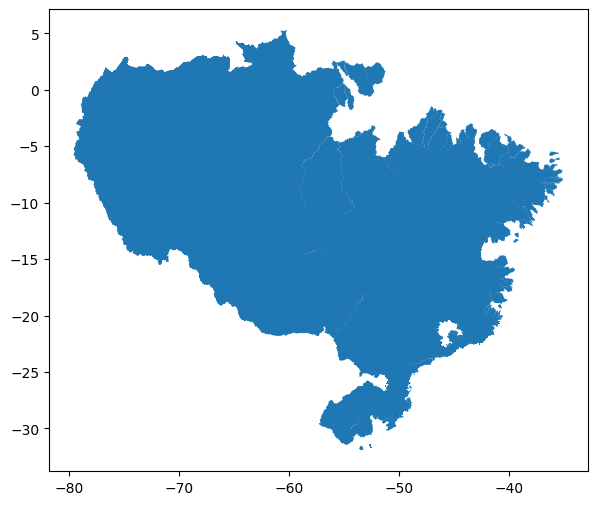

In [8]:
# Plot all the catchments
fig, ax = plt.subplots(figsize=(8,6))
shp_CABra.plot(ax=ax)
plt.show()

In [9]:
# Encontrando a linha do dataframe que tem o ID_CABra == 1
shp_CABra[shp_CABra['ID_CABra']==1]

area_CABra   gauge_ANA  ID_CABra  X_outlet  Y_outlet  \
352  243410.278886  13880000.0       1.0   -64.384    -6.541   

                                              geometry  
352  MULTIPOLYGON (((-68.44875 -7.14875, -68.44708 ...

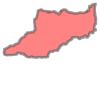

In [10]:
shp_CABra.loc[352,'geometry']

In [11]:
shp_CABra.loc[352]

area_CABra                                        243410.278886
gauge_ANA                                            13880000.0
ID_CABra                                                    1.0
X_outlet                                                -64.384
Y_outlet                                                 -6.541
geometry      MULTIPOLYGON (((-68.4487499994223 -7.148749999...
Name: 352, dtype: object

In [12]:
#get shape from watershed 352
shape_352 = shp_CABra.loc[shp_CABra['ID_CABra']==1]

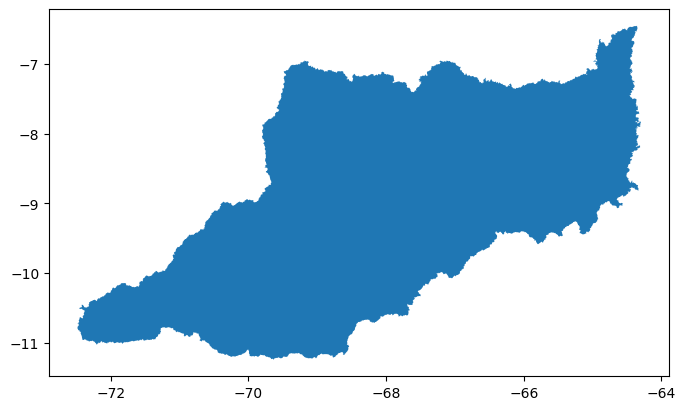

In [13]:
# Plot all the catchments
fig, ax = plt.subplots(figsize=(8,6))
shape_352.plot(ax=ax)
plt.show()

Do mapa acima podemos ver que os limites são:

* latitude: -6 a -12 graus
* longitude -64 a -73 graus

In [14]:
shape_352.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
# Adicionar um base map no fundo
df_wm = shape_352.to_crs(epsg=3857)

<Axes: >

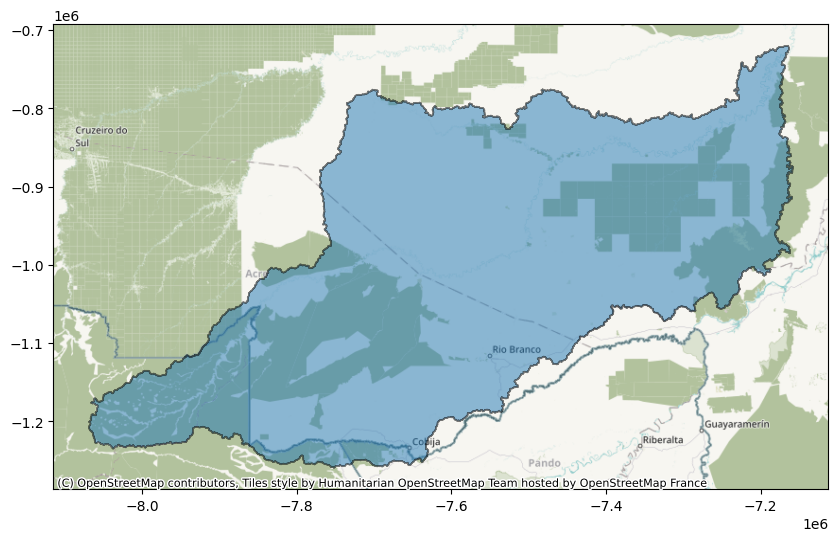

In [16]:
ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
cx.add_basemap(ax)
shape_352.plot(ax=ax)
#plt.show()

## Obtendo o modelo digital do terreno


1. Acessar o site: https://portal.opentopography.org/ (se registrar no site antes), procurar SRTM e acessar SRTM15+
2. Encontrar as coordenadas geográficas de uma **região maior** do que a bacia de interesse.  Otimizar processo por tentativa e erro.
3. Fazer o download do Raster SRTM15+
4. Adicionar o Raster no seu Google Drive e Compartilhar. Usar opção: `Qualquer pessoa com o link`
5. Obter o link e copiar o códido dentro do endereço do link, por exemplo:

Link:
https://drive.google.com/file/d/1d8Abmy_g2s4_Sn-mrfiRrI5xRY_jSN3K/view?usp=sharing

Parte interna: 1d8Abmy_g2s4_Sn-mrfiRrI5xRY_jSN3K

In [17]:
!gdown '16JO8Wlt1h8zGi1h1ZfjuF89HMwuJPE8m' --output output_SRTM15Plus_am.tif

Downloading...
From: https://drive.google.com/uc?id=16JO8Wlt1h8zGi1h1ZfjuF89HMwuJPE8m
To: /content/output_SRTM15Plus_am.tif
100% 3.73M/3.73M [00:00<00:00, 72.7MB/s]


In [18]:
# rename a file in google colab
!mv output_SRTM15Plus_am.tif raster_SRTM.tif

## Lendo o arquivo raster (*.tif)

In [19]:
grid = Grid.from_raster('raster_SRTM.tif')
dem = grid.read_raster('raster_SRTM.tif')

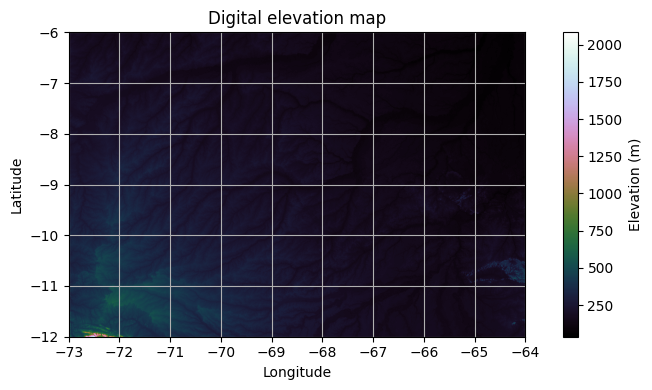

In [20]:
fig, ax = plt.subplots(figsize=(8,4))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='cubehelix', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.savefig('img/conditioned_dem.png', bbox_inches='tight')

# Resolve flats in DEM

In [21]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)

# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

# Specify flow direction values

In [22]:
         #N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Convert DEM to flow direction grid

In [23]:
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

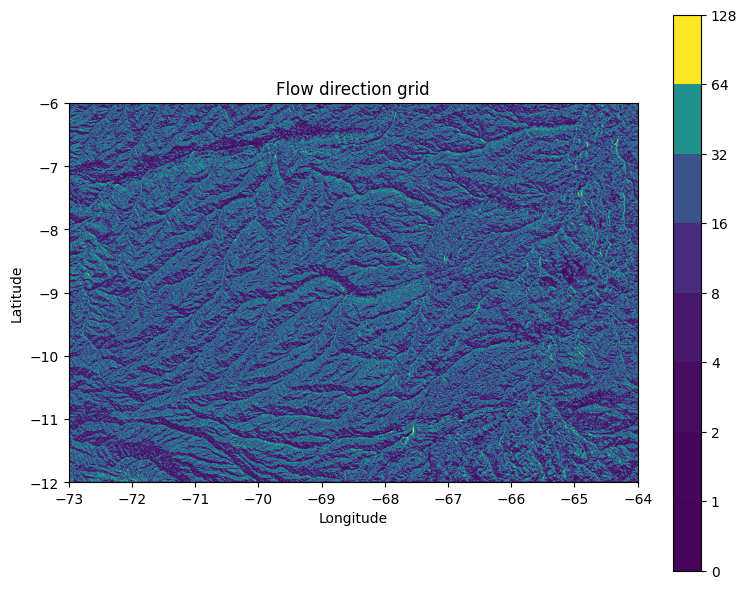

In [24]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid')
plt.grid(zorder=-1)
plt.tight_layout()
plt.savefig('img/flow_direction.png', bbox_inches='tight')

In [25]:
# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

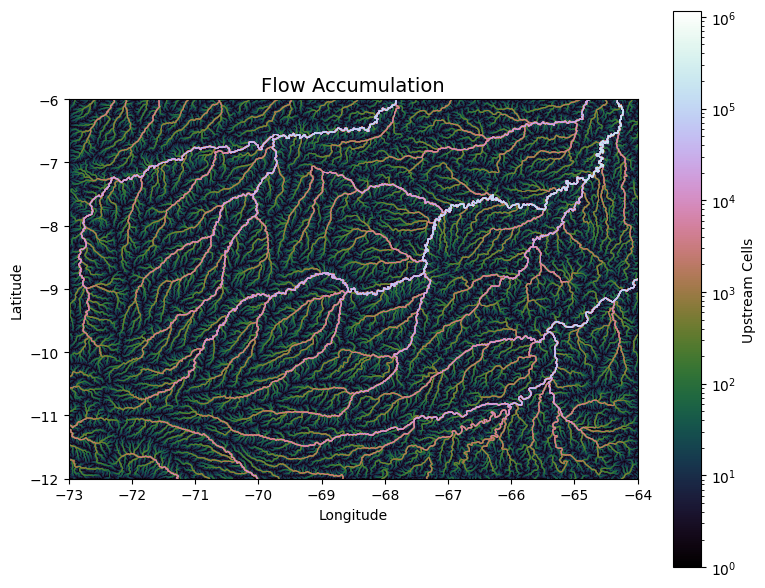

In [26]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

# Encontrar as coordenadas geográficas do posto pluviométrico

Onde encontrar?
* Site da Agência Nacional de Águas (ANA)
* Agências estaduais do meio ambiente
* Plano de Bacia
* **CABra dataset** - Catchments Attributes for Brazil (CABra)

# Delineamento da bacia

In [27]:
# Specify pour point
x, y = -64.384, -6.541  # graus (CABra)
# Outros locais para encontrar as coordenadas ANA, Planos de Bacias (postos fluviometricos)

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                       xytype='coordinate')

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

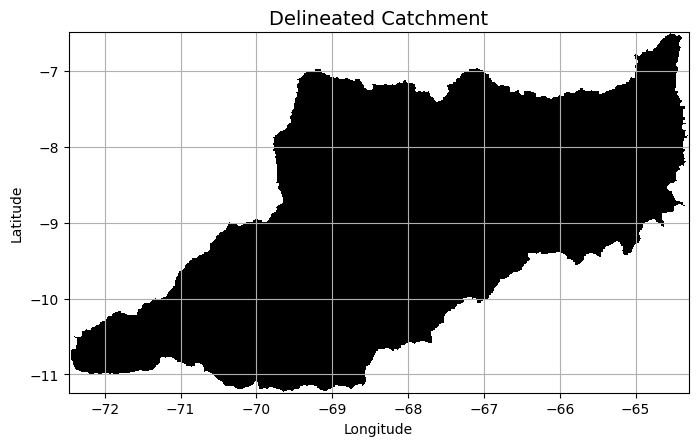

In [28]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)
plt.savefig('img/catchment.png', bbox_inches='tight')

## Criar uma representação vetorial da máscara da bacia

In [29]:
# The polygonize argument defaults to the grid mask when no arguments are supplied
shapes = grid.polygonize()

In [30]:
!mkdir shapefiles

In [31]:
schema = {
    'geometry': 'Polygon',
    'properties': {'LABEL': 'float:16'}
}

with fiona.open('shapefiles/catchment.shp', 'w',
                driver='ESRI Shapefile',
                crs=grid.crs.srs,
                schema=schema) as c:
    i = 0
    for shape, value in shapes:
        rec = {}
        rec['geometry'] = shape
        rec['properties'] = {'LABEL' : str(value)}
        rec['id'] = str(i)
        c.write(rec)
        i += 1

In [32]:
shp = gpd.read_file('shapefiles/catchment.shp')

In [33]:
shp

LABEL                                           geometry
0      1  POLYGON ((-64.35833 -7.55417, -64.35417 -7.554...
1      1  POLYGON ((-64.54167 -6.49167, -64.53333 -6.491...

Text(0.5, 1.0, 'Catchment polygon')

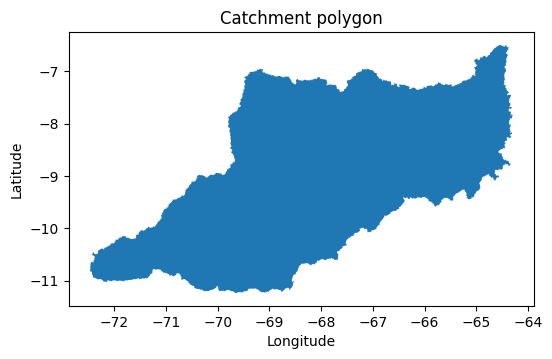

In [34]:
fig, ax = plt.subplots(figsize=(6,6))
shp.plot(ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Catchment polygon')

## Alteração Projeção (Coord. Geo -> UTM)

Para alterar a projeção vamos precisar saber qual código EPSG temos na nossa zona UTM.


| DATUM | CóDIGO EPSG |
| :--- | :--- |
| WGS 1984 / UTM zone 18N | 32618 |
| WGS 1984 / UTM zone 18S | 32718 |
| WGS 1984 / UTM zone 19N | 32619 |
| WGS 1984 / UTM zone 19S | 32719 |
| WGS 1984 / UTM zone 20N | 32620 |
| WGS 1984 / UTM zone 20S | 32720 |
| WGS 1984 / UTM zone 21N | 32621 |
| WGS 1984 / UTM zone 21S | 32721 |
| WGS 1984 / UTM zone 22N | 32622 |
| WGS 1984 / UTM zone 22S | 32722 |
| WGS 1984 / UTM zone 23S | 32723 |
| WGS 1984 / UTM zone 24S | 32724 |
| WGS 1984 / UTM zone 25S | 32725 |

In [35]:
# insert image in a text cell from link in dropbox
from IPython.display import Image
Image(url="https://www.dropbox.com/scl/fi/8nsn6fme813szdpcghqow/Fusos-e-hemisferios-da-projecao-UTM-para-o-Brasil.jpg?rlkey=d7nydohmna1lh5qlm5vebrujj&dl=1", width=400)


In [36]:
shp2 = shp.to_crs({'init':'epsg:32719'})

In [39]:
shp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [40]:
shp2.crs

<Projected CRS: EPSG:32719>
Name: WGS 84 / UTM zone 19S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 72°W and 66°W, southern hemisphere between 80°S and equator, onshore and offshore. Argentina. Bolivia. Brazil. Chile. Colombia. Peru.
- bounds: (-72.0, -80.0, -66.0, 0.0)
Coordinate Operation:
- name: UTM zone 19S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Calcular a Área

In [41]:
shp2

LABEL                                           geometry
0      1  POLYGON ((1012593.434 9162255.085, 1013054.553...
1      1  POLYGON ((993429.830 9280271.268, 994353.964 9...

Text(0.5, 1.0, 'Catchment polygon')

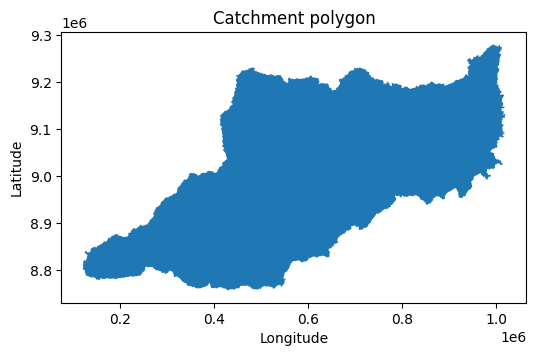

In [42]:
fig, ax = plt.subplots(figsize=(6,6))
shp2.plot(ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Catchment polygon')

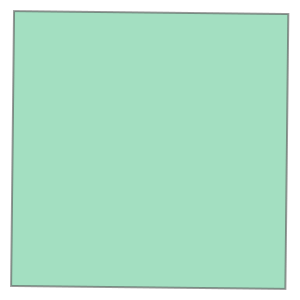

In [43]:
shp2.loc[0,'geometry']

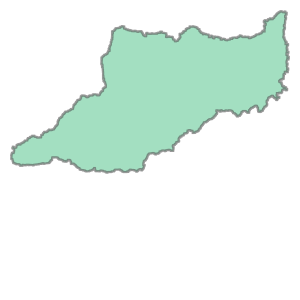

In [44]:
shp2.loc[1,'geometry']

In [45]:
from shapely.geometry import shape

In [46]:
shape(shp2.loc[1,'geometry']).area

236301986946.40762

### Conferir Área com documentos oficiais

Área = 236301986946.40762 m$^2$

Conferir na plataforma da ANA e comitês de bacias

In [48]:
for i in range(len(shp2)):
  shp2.loc[i,'area_m2'] = shape(shp2.loc[i,'geometry']).area

In [49]:
shp2

LABEL                                           geometry       area_m2
0      1  POLYGON ((1012593.434 9162255.085, 1013054.553...  2.131048e+05
1      1  POLYGON ((993429.830 9280271.268, 994353.964 9...  2.363020e+11

In [50]:
shp2['area_km2'] = shp2['area_m2']/1000000

In [51]:
shp2

LABEL                                           geometry       area_m2  \
0      1  POLYGON ((1012593.434 9162255.085, 1013054.553...  2.131048e+05   
1      1  POLYGON ((993429.830 9280271.268, 994353.964 9...  2.363020e+11   

        area_km2  
0       0.213105  
1  236301.986946

# Comprimir (Zipar) e fazer o download do arquivo

In [52]:
!zip -r /content/shapefile.zip /content/shapefiles

  adding: content/shapefiles/ (stored 0%)
  adding: content/shapefiles/catchment.prj (deflated 17%)
  adding: content/shapefiles/catchment.shp (deflated 82%)
  adding: content/shapefiles/catchment.cpg (stored 0%)
  adding: content/shapefiles/catchment.shx (deflated 51%)
  adding: content/shapefiles/catchment.dbf (deflated 65%)


In [53]:
from google.colab import files
files.download("/content/shapefile.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>